## Import Libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
plt.rcParams['figure.figsize'] = (12,6)

## Import Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/data/ADBL_data.csv')
df['Date'] = pd.to_datetime(df.Date)
# df = df[df['Date'] >= '2015-01-01']
df.head()

,Date,Open,High,Low,Close
0,2012-01-01,115.0,115.0,113.0,114.0
1,2012-01-02,114.0,118.0,115.0,118.0
2,2012-01-03,118.0,116.0,114.0,115.0
3,2012-01-04,115.0,115.0,113.0,114.0
4,2012-01-05,114.0,114.0,112.0,113.0


## Time Series chart of ADBL

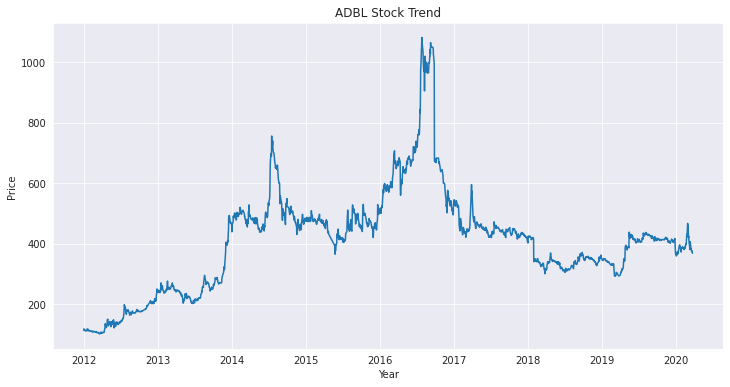

In [ ]:
plt.plot(df["Date"], df["Close"])
plt.title("ADBL Stock Trend")
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [ ]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,2012-01-01,114.0
1,2012-01-02,118.0
2,2012-01-03,115.0
3,2012-01-04,114.0
4,2012-01-05,113.0


# Test for Stationarity

In [ ]:
df['returns'] = df.Close.pct_change() * 100
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.head()

,index,Date,Close,returns
0,1,2012-01-02,118.0,3.508772
1,2,2012-01-03,115.0,-2.542373
2,3,2012-01-04,114.0,-0.869565
3,4,2012-01-05,113.0,-0.877193
4,5,2012-01-08,114.0,0.884956


## Rolling mean and standard deviation

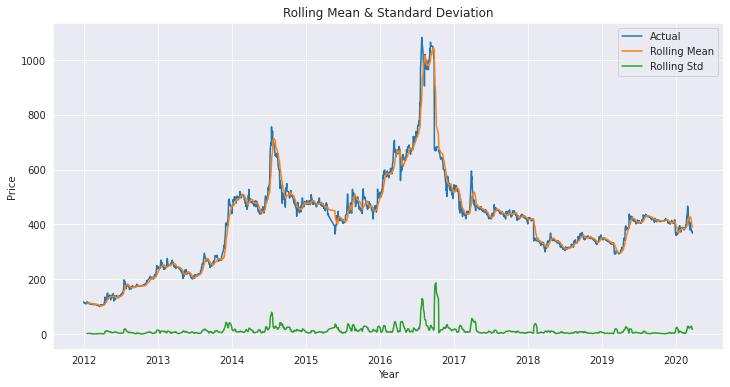

In [ ]:
# High level overview of Closing price to see if it is stationary or not

rolling_mean = df['Close'].rolling(12).mean()
rolling_std = df['Close'].rolling(12).std()

plt.title('Rolling Mean & Standard Deviation')
plt.plot(df['Date'], df['Close'], label='Actual')
plt.plot(df['Date'], rolling_mean, label='Rolling Mean')
plt.plot(df['Date'], rolling_std, label='Rolling Std')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

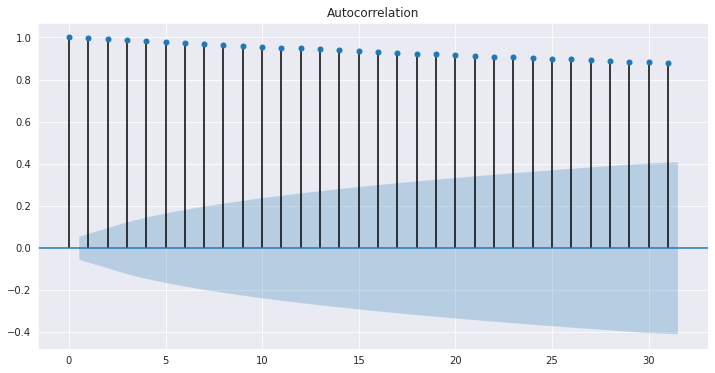

In [ ]:
# Autocorrelation Function (ACF) plot without any differencing
plot_acf(df.Close)
plt.show()

## ADF Test

**Hypothesis Testing**

Check whether the target variable is stationary or not

Ho - It is non stationary (Null Hypothesis)

H1 - It is stationary (Alternate Hypothesis)

In [ ]:
result = adfuller(df['Close'])

print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')
print('H1: The series is stationary' if result[1] <= 0.05 else 'H0: The series is non stationary')

ADF Statistic: -1.6781735495148635, p-value: 0.4423917477805401
H0: The series is non stationary


In [ ]:
# Testing the series for stationarity with differencing of 1
result = adfuller(df['Close'].diff().dropna())

print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')
print('H1: The series is stationary' if result[1] <= 0.05 else 'H0: The series is non stationary')

ADF Statistic: -32.694218028296994, p-value: 0.0
H1: The series is stationary


Identifying d: the number of times that the raw observations are differenced

In [ ]:
# The series was stationary with differencing of 1
d = 1
print(f'Degree of differencing: {d}')

Degree of differencing: 1


Identifying p : the number of lag observations

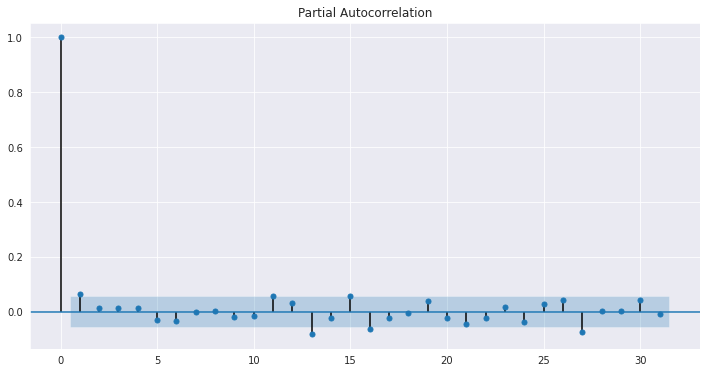

In [ ]:
# Partial Autocorrelation Function (PACF)
diff = df.Close.diff().dropna()

plot_pacf(diff)
plt.show()

*Here lag 1 stands out and is well above the significance line.* Hence, **p** is **1**

In [ ]:
p = 1

Identifying q: the size of the moving average window

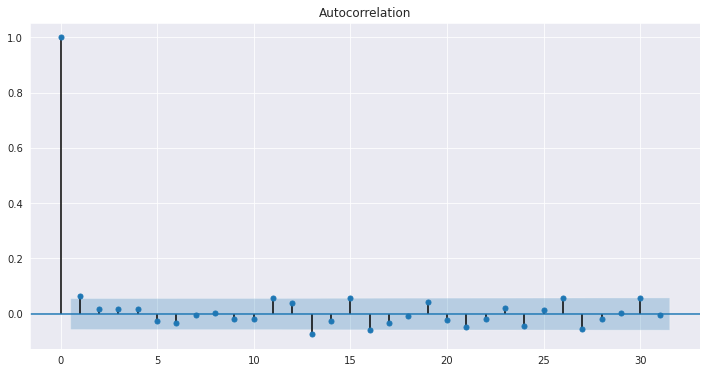

In [ ]:
# Autocorrelation Function (ACF)
diff = df.Close.diff().dropna()

plot_acf(diff)
plt.show()

*Here lag 1 stands out and is well above the significance line.* Hence, **q** is **1**

In [ ]:
q = 1

In [ ]:
print(f'ARIMA order is ({p}, {d}, {q})')

ARIMA order is (1, 1, 1)


## Train/Test Split

In [ ]:
# Split Train and Test set into 70/30 percent
X_train, X_test = train_test_split(df.Close, test_size=0.30, shuffle=False)
print(X_train.shape, X_test.shape)

(856,) (367,)


## Fit ARIMA Model

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ARIMA Model
model = ARIMA(X_train, order=(p, d, q))
result = model.fit(disp=0)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  855
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3706.261
Method:                       css-mle   S.D. of innovations             18.465
Date:                Thu, 24 Jun 2021   AIC                           7420.522
Time:                        18:43:29   BIC                           7439.526
Sample:                             1   HQIC                          7427.799
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.2875      0.698     -0.412      0.680      -1.655       1.080
ar.L1.D.Close     0.3136      0.344      0.912      0.362      -0.360       0.987
ma.L1.D.Close    -0.2413      0.351     -0.688      0.492      -0.929       0.446
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1891           +0.0000j            3.1891            0.0000
MA.1            4.1446           +0.0000j            4.1446            0.0000
-----------------------------------------------------------------------------
"""

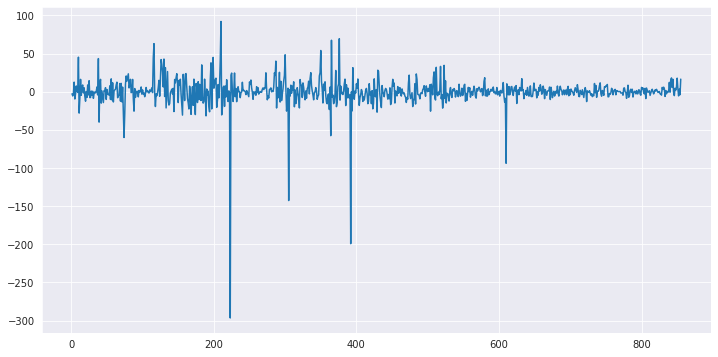

In [ ]:
# Plotting residual errors
residuals = pd.DataFrame(result.resid)

plt.plot(residuals)
plt.show()

# The residual mean is centered around 0

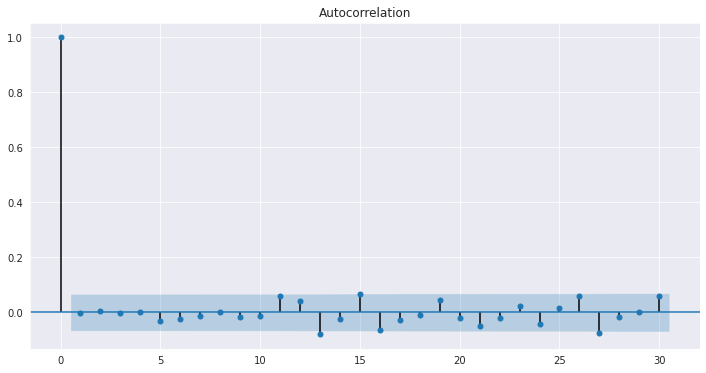

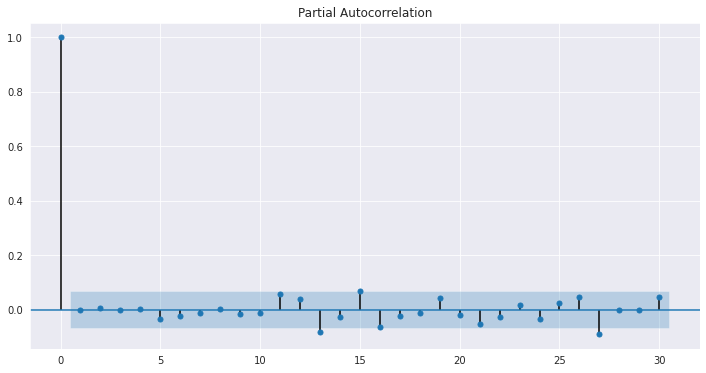

In [ ]:
# ACF and PACF plots of the residuals
plot_acf(residuals)
plot_pacf(residuals)
plt.show()

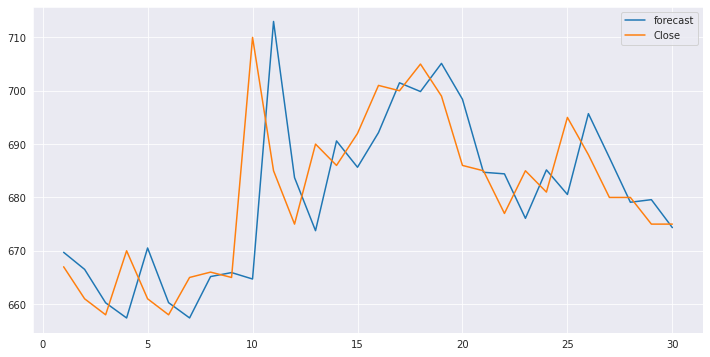

In [ ]:
# Predict Train set
result.plot_predict(
    start=1,
    end=30,
    dynamic=False,
);

In [ ]:
yhat_train = result.predict(start=1)
returns_train = df.returns[1:X_train.shape[0]]

In [ ]:
trainScore = mean_squared_error(returns_train, yhat_train, squared=False)
print("Train Score: %.2f RMSE" % (trainScore))

Train Score: 2.78 RMSE


## Forecasting Test set

In [ ]:
model = ARIMA(X_train, order=(p, d, q))
result = model.fit(disp=0)

yhat_test, se, conf = result.forecast(X_test.shape[0])

In [ ]:
test_date = df.Date[X_train.shape[0]:]
yhat_test = pd.Series(yhat_test)
lower = pd.Series(conf[:, 0])
upper = pd.Series(conf[:, 1])

In [ ]:
returns_test = df.returns[-X_test.shape[0]:]

In [ ]:
testScore = mean_squared_error(X_test, yhat_test, squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 95.04 RMSE


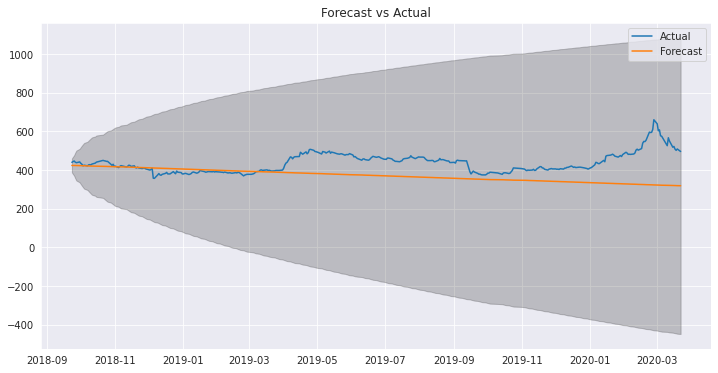

In [ ]:
plt.title("Forecast vs Actual")
plt.plot(test_date, X_test, label="Actual")
plt.plot(test_date, yhat_test, label="Forecast")
plt.fill_between(test_date, lower, upper, color="k", alpha=0.2)
plt.legend()
plt.show()

Here, ARIMA model is used to forecast all of the test data based on the model fitted on training set.

The forecasted price is not that great. However, the confidence interval covers the actual price.

## Rolling Forecast on Test set

In [ ]:
x_train = list(X_train)
x_test = list(X_test)
forecasts = list()
for i in range(X_test.shape[0]):
  model = ARIMA(x_train, order=(p, d, q))
  result = model.fit(disp=0)
  yhat = list(result.forecast()[0])[0]
  forecasts.append(yhat)
  x_train.append(x_test[i])


In [ ]:
testScore = mean_squared_error(x_test, forecasts, squared=False)
print("Test Score: %.2f RMSE" % (testScore))

Test Score: 9.37 RMSE


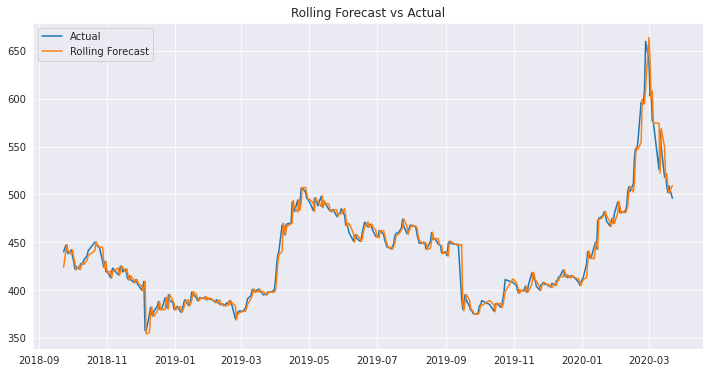

In [ ]:
plt.title("Rolling Forecast vs Actual")
plt.plot(test_date, X_test, label="Actual")
plt.plot(test_date, forecasts, label="Rolling Forecast")
plt.legend()
plt.show()

Significant improve in RMSE of rolling forecasts.